# Data Science Challenge

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd gdrive/My Drive/Colab/ML-for-Chemical-Engineering-Research

## Problem statement
Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices. In this notebook, we provide analysis and insights for Fraud action in credit card transactions. For the challenge, we will use credit card transaction data.
<br>

By following the table of contents, we will find a general description of collected data, detailed illustration and analysis of the dataset, and a predictive model to determine whether a given transaction will be fraudulent or not.

### Table of Contents

I.    [Programmatically load dataset](#Load)<br>
II.   [Plot and general analysis of dataset](#Plot)<br>
III.  [Data Wrangling - Duplicate Transactions](#Clean)<br>
IV.   [Fraud detection model](#Model)<br>
V.   [Reference](#Ref)

### Bullet points and logic path
**Question 1: Load</font>**
<br>`a.` Dataset is downloaded and parsed into **pandas DataFrame** through git
<br>`b.` **Shape** of the dataset and **Type**, **Count** of individual features is provided, Features are categories into four groups according to data type 
<br>`c.` **Num of Null**, **Min**, **Max**, **UniqueValue** and **numerical statistics** of individual features is sumerized
<br>`d.` Empty columns **echoBuffer**, **merchantCity**, **merchantState**, **merchantZip**, **posOnPremises**, **recurringAuthInd** are removed

**Question 2: Plot</font>**
<br>`a.` **Histogram plot** and **box chart** of the processed amounts is provided
<br>`b.` **Histogram** of Fraud vs normal transactions are compared
<br>`c.` Majority numeric features follows a **asymmetric distribution patterns**, usually **right skew**
<br>`d.` **Correlation heat map** of features is provided
<br>`e.` **Hypothesis 1:** Fraud transaction are more likely to appear on bigger amount.
<br>`f.` **Hypothesis 2:** If cardCVV is not equal to entered CVV, the corresponding transaction is highly possible to be a Fraud.
<br>`g.` **Hypothesis 3:** Features are not independent between each other (currentbalance, creditlimit, avaiablemoney)

**Question 3: Data Wrangling</font>**
<br>`a.`The dataset contains duplicate items other than Reverse transactions and multi-swipe transactions
<br>`b.`There are **20303** record of reversal transactions, with total amount of **2821792** dollars
<br>`c.`There are **2477** record of multi-swipe transactions, with total amount of **389751** dollars (**repeat transaction with time sequence less then 2mins is treated as multi-swipe**)
<br>`d.`Fraud transactions are more common on **REVERSE** transactions 
<br>`e.`**Time**, **merchantName** features are reshaped before modeling

**Question 4: Model</font>**
<br>`a.` Models are designed to emphasize more on **Sensitivity**
<br>`b.` **Clustering** was tried, but **failed** due to **curse of dimensions**
<br>`c.` **Positively skewed distribution** pattern of specific features are emphasized
<br>`d.` Simple Logistic Regression Model is built with AUC 0.510732
<br>`e.` **Logistic Regression Model** is optimized with **SMOT** technique to deal with **imbalance distribution**
<br>
<br> **Performance of optimized model:**
- Accuracy: 0.98
- Precision: 0.13
- Recall: 0.071
- Average precision-recall score: 0.06
- **AUC** : 0.75

In [1]:
import pandas as pd
import os  
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.style as style
import math
import seaborn as sns

### <a class="anchor" id="Load">Part I : Programmatically load dataset</a>

### <font size="+1">Question 1: Load</font>
`1.` Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found here
<br>
`2.` Please describe the structure of the data. Number of records and fields in each record?
<br>
`3.` Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

**1.** **Extract transform and load data**

In [2]:
# clone Capital One Challenge repository 
!git clone https://github.com/CapitalOneRecruiting/DS.git
f_name = "DS/transactions.zip"
# read .zip file and extract all files
with ZipFile(f_name, 'r') as zip: 
    # print contents of the corresponding directory
    zip.printdir() 
    # extract all files in transactions.zip
    zip.extractall() 
# since the dataset provided is in json format, we can change the filename and parse to pandas dataFrame
os.rename('transactions.txt','transactions.json')
# convert json strings to pandas dataFrame 
df = pd.read_json ('transactions.json',lines=True)
df.to_csv('transaction.csv')

fatal: destination path 'DS' already exists and is not an empty directory.
File Name                                             Modified             Size
transactions.txt                               2020-01-07 21:32:42    609937737


### To-do: Shows General View of the Dataset

In [3]:
# show example of the dataset
# df.head()

In [4]:
# show number of columns and number of rows in the dataset
# shape = df.shape
# print("Dataset Dimensions: {%d} x {%d}" %(shape[0],shape[1]))

**2.** **Describe the structure of the data**
* The shape of the data set is 786363 (row) * 29 (column)
* There are 3 boolean variables, 4 numerical features, and 22 object features in the dataset, column **isFraud** works are **label data** in model building
* Features could also be categorized into the following 4 class based on datatype and meaning:
    - Customer: customerId, accountNumber
    - Credit: creditLimit, availableMoney, currentExpDate, accountOpenDate, dateOfLastAddressChange, cardCVV, enteredCVV, cardLast4Digits, currentBalance, cardPresent, expirationDateKeyInMatch
    - Mechant: merchantCity, merchantState, merchantZip, merchantName, merchantCountryCode, merchantCategoryCode
    - Transaction: transactionDateTime, transactionAmount, transactionType
    - Pos: posEntryMode, posConditionCode, posOnPremises
* Column echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd are empty columns, thus they **should be removed** for efficiency enhancement while conduct data cleaning

In [5]:
# categorize features according to datatype
time_col = ['dateOfLastAddressChange', 'currentExpDate', 'accountOpenDate', 'transactionDateTime']
int_col = ['cardCVV',  'cardLast4Digits', 'enteredCVV']
cat_col = ['customerId', 'accountNumber','merchantCategoryCode', 'posConditionCode', 'posEntryMode', 'transactionType', 'acqCountry', 'merchantCountryCode']
str_col = ['merchantName']

In [6]:
# fill in empty cells with np.nan 
shape = df.shape
for col in df.columns:
    df[col] = df[col].map(lambda x: np.nan if x == "" else x)
# check for the number of nan in each column
df_null_count = df.isnull().sum()
empty_col = []
partmiss_col = []
for col in df_null_count.index:
    if df_null_count[col] == shape[0]:
        empty_col.append(col)
    elif df_null_count[col] != 0:
        partmiss_col.append(col)
print("Empty columns:",empty_col)
print("Partial Missing columns",partmiss_col)

Empty columns: ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']
Partial Missing columns ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType']


**Empty columns** are droped, while **Partial Missing columns** need to be filled

**<font size="+1">Handle missing Data**
<br>Features with partial missing are classification type of data, thus missing cells can be replaced with nan(string type). Since we already map the missing cells with np.nan, we will just convert them into string type for easier processing

In [7]:
print(partmiss_col)
for col in partmiss_col:
    df[col] = df[col].astype(str)

['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType']


**3.** **Additional basic summary for each field**

#### From the above table we can extract the following key infomation:
- There are 5000 unique users in the dataset
- Features **echoBuffer**, **merchantCity**, **merchantState**, **merchantZip**, **posOnPremises**, **recurringAuthInd** are missing 
- Features **acqCountry**, **merchantCountryCode**, **posEntryMode**, **posConditionCode**, **transactionType** have missing elements

### Todo: provide statistic information for numerical features

In [8]:
#num_col = ['creditLimit','availableMoney','transactionAmount','currentBalance']
#df[num_col].describe()

From the statistics of numerical features we observe, most of the numerical features follow **asymmetric distribution**. The majority of numeric features **skew to the right** hand side, which indicates a larger portion of transactions concentrated in the small amount range but with high variation.

In [9]:
# drop redundant columns 
df.drop(empty_col, axis = 1, inplace = True)

### <a class="anchor" id="Plot">Part II : Plot and general analysis of dataset</a>

####  <font size="+1">Question 2: Plot
`1.` Plot a histogram of the processed amounts of each transaction, the transactionAmount column.<br>
`2.` Report any structure you find and any hypotheses you have about that structure.

**1.** **Histogram and box chart of the processed amounts of each transaction**<br>

**2.** **Report any structure you find and any hypotheses you have about that structure**<br>

Base on the histogram of the processed amount of each transaction, we justify our hypothesis that the distribution **skew to the right**. And the majority of the process concentrated on the 0 to 500 dollar range. If we compare the distribution of Fraud transactions and normal transactions, we believe there is an observable difference between them based on the transaction amounts.

- The distribution of real transaction amounts is more skewed to the right comparing with that of fraud transactions. Based on this observation we proposed **hypothesis 1: Fraud transactions are more likely to appear on the bigger amount.** which makes sense in the realistic condition. 

- Average of real transaction amounts is 136 dollars, much less than the average of fraud transaction amounts, 225 dollars. 50% of real transaction amounts are under 87 dollars also less than that of fraud transaction amounts, under 177 dollars. Meanwhile, 25% of fraud transaction amounts are under 87 dollars, and 50% of normal transaction amounts are under 87 dollars. 

- The maximum transaction amounts of the normal transaction is 2011.54 dollars, 400 dollars larger than the maximum transaction amounts of fraud transaction.

Explanation of **hypothesis 1**: Frauds are less likely to happen among small transactions since the risk of getting caught weighs heavier than the potential gain. Medium to large transactions (50 to 120 dollars) might be the target range for internet fraud.  

Feature **avaiableMoney** and **currentBalance** follows **positively skewed** distribution pattern. And **creditLimit** follows **multi-Gaussian** distribution. These asymmetric numerical features should be emphasized, and adjusted in model construction.

### To-do: Shall we input all the features into the modeler?

In [12]:
# plot heat map of correlation between variables
corr = df.corr()

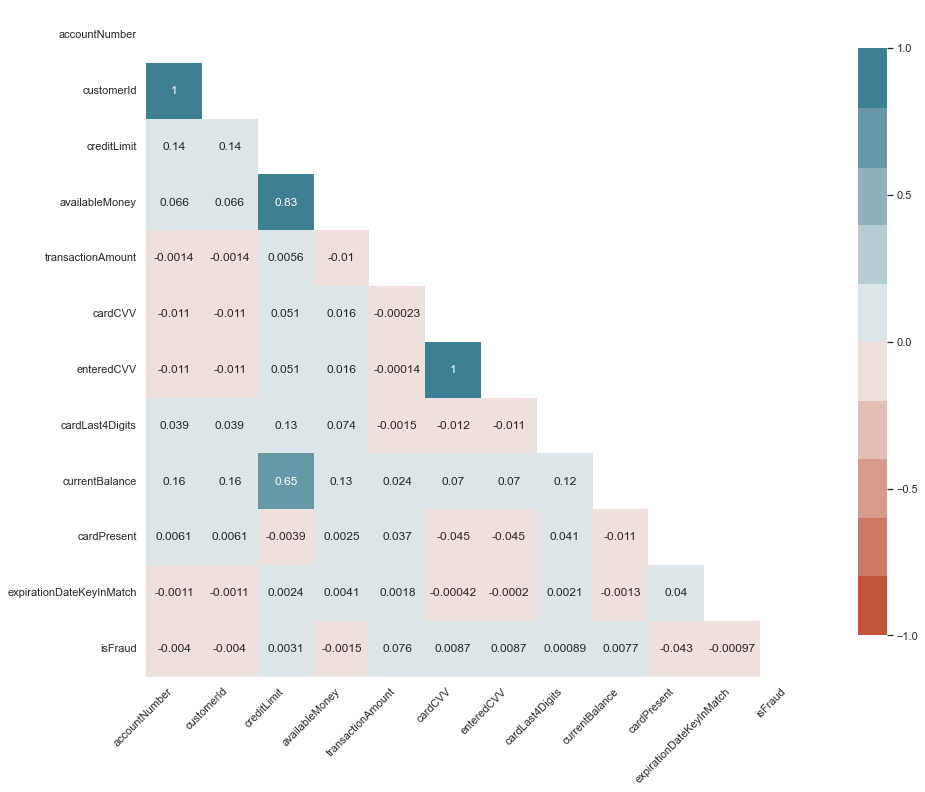

In [13]:
# sns heat map https://seaborn.pydata.org/generated/seaborn.heatmap.html
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
# remove the top right triangle of the heat map
sns.set(font_scale= 1)
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15, 18))
    sns.heatmap(corr, vmin = -1, vmax = 1,
                center = 0,cmap=sns.diverging_palette(20, 220, n=10),
                annot = True, mask = mask,square = True,
                cbar_kws = {'shrink': .6, 'ticks' : [-1, -.5, 0, 0.5, 1]},
               annot_kws={"size": 12})
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

**Based on the correalation heat map, we observe:**
- feature cardCVV is almost identical to enteredCVV. They are not exactly the same. **Hypothesis 2**: If cardCVV is not equal to entered CVV, the corresponding transaction is highly possible to be a Fraud.    
- current balance can be calculated with available money and credit limit. **Hypothesis 3**: features are not independent of each other
- customerID is the same with accountNumber, in this way one of them should be removed

### <a class="anchor" id="Clean">Part III : Data Wrangling - Duplicate Transactions</a>

####  <font size="+1">Question 3: Data Wrangling - Duplicate Transactions
You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

`1.` Can you programmatically identify reversed and multi-swipe transactions?<br>
`2.` What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)<br>
`3.` Did you find anything interesting about either kind of transaction?

There are no complete duplicate record in transaction dataset

**1.** **Identification of reversed and multi-swipe transactions**
<br>**a.** **reversal transactions** 
- Reversal transactions are labeled as **REVERSAL** in the transactionType field
- There are **20303** record of reversal transactions, with total amount of **2821792** dollars

**b.** **multi-swipe transactions:**
<br> multi-swipe transactions are transaction processed repreatedly. In this way, muti-swipe transactions should follows 
<br>`1.`have the same **merchantName**, **accountNumber**, **transactionAmount**, **cardLast4Digits**
<br>`2.`difference of **transactionDateTime** between transactions is in short time period (**threshold 2mins**)

No money transfered in **ADDRESS_VERIFICATION** type of transactions

In [14]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


**Format unification**

In [13]:
# modify time features
import datetime
df['transactionDateTime'] = df['transactionDateTime'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))
df['accountOpenDate'] = df['accountOpenDate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df['currentExpDate'] = df['currentExpDate'].apply(lambda x: datetime.datetime.strptime(x, '%m/%Y'))
df['dateOfLastAddressChange'] = df['dateOfLastAddressChange'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
# unify feature type
for col in int_col:
    df[col] = df[col].astype(int)

**2.Total number of transactions and total dollar for the reversed transactions and multi-swipe transactions**

There are **20303** record of reversal transactions, with total amount of **2821792** dollars
<br>There are **2146** record of multi-swipe transactions, with total amount of **450488** dollars 

**3. Interesting patterns**

It is interesting to see that fraud transactions are more common in **Reversal** Transactions. People could lose vigilance when conducting a REVERSE Transaction, thus could possibly get caught by the fraud.

**Reshape time features**\
<br> Pure time label might be losely correlated with Fraud action. Reshape time stamp could bring more insight.
<br> We make the hypothesis that Fraud action could relate to the length of time sequece between transaction time and now or account open date. In this way we create two features:
<br>`1.` fromOpenToTransaction = diff (transactionDateTime , accountOpenDate)
<br>`2.` fromTransactionToNow = diff (currentExpDate , transactionDateTime)
<br>`3.` fromTransactionToChange = diff (transactionDateTime,  dateOfLastAddressChange)
<br>`4.` ageOfAccount = diff (currentExpDate , accountOpenDate)

In [14]:
# convert data information to reshaped furtures above
df['fromOpenToTransaction'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
df['fromTransactionToNow'] = (df['currentExpDate'] - df['transactionDateTime']).dt.days
df['fromTransactionToChange'] = (df['transactionDateTime'] - df['dateOfLastAddressChange']).dt.days
df['ageOfAccount'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days

In [15]:
# remove oringinal data from the dataset
df.drop(['accountOpenDate','transactionDateTime','currentExpDate','dateOfLastAddressChange'],axis = 1, inplace = True)

**Reshape merchantName feature**

merchantName is a string object. Simple **one-hot encoding is not a good idea** Since it will lead to the **curse of dimentionality**. In this way, efficiently encoding merchantName feature is required. In this project, we reshape the merchantName feature to **number of times it has received fraud transaction**. And replace the merchantName with Fraud frequency. This procedure may lose some information about the merchant itself, but the idea is worth trying. 

In [16]:
merchant_f = df[df['isFraud']==True]
df_merchant = merchant_f.groupby('merchantName').size()
# encloding merchant name with times of fraud transaction in the dataset, for fast extraction using a hashmap
merchant_dic = df_merchant.to_dict()
df['merchantName'] = df['merchantName'].apply(lambda x: int(merchant_dic[x]) if x in merchant_dic else 0)

### <a class="anchor" id="Model">Part IV : Fraud detection model</a>

####  <font size="+1"> Question 4: Model
Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.

`1.` Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).<br>
`2.` Provide an estimate of performance using an appropriate sample, and show your work.<br>
`3.` Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

Our motivation in this project is to build a predictive model for this **classification problem**. Sensitively catch Fraud transactions are the main target. Since **Flase Positive is more acceptable than False Negative**. In this way, we should emphasize more on **Sensitivity** of the model. Ideally a **top left-shifted ROC curve** is our target. In this dataset we have over 40 features, in this way, working with **clustering (k-mean algorithm) may not be a good idea** since it might lead us to **the curse of dimensions**. 

The difficulty of building a sensitive model is to **deal with the skewed features in the dataset.**. As previously discussed, we found numerical features, such as **availableMoney**, **currentBalance** are extremely **right skewed**. Solving the problem of imbalanced features requires some extra thoughts.   

Due to the **time and computational resource limit**, I decided to focus on **Logistic Regression**. Even though It do not work well with imbalanced data, it can still be optimized with **Over sampling** techniques, which leave room for further modification. <br>
<br>`a.` Logistic Regression can quickly classify large volumes of data with relatively low computational cost
<br>`b.` The predictive analytics algorithms can be enhanced using **Oversampling technique**. And improve the model performance on **asymmetric features**.

In [16]:
# prepare the training matrix for modeling
# category features require tokenization
cat_col = ['posConditionCode','merchantCountryCode','acqCountry','merchantCategoryCode','transactionType','posEntryMode']
df_cat = pd.get_dummies(df[cat_col])
# merge the remaining part of the dataset
df_res = df.drop(cat_col,axis = 1)
df_clean = pd.concat([df_cat, df_res], axis=1)

In [17]:
# save cleaning dataset as backup
df_clean.to_csv('transaction_clean.csv', index=False)

**Logistic Regression** (without asymmetry adjustment)
<br>
Simpe logistic regression model is built for a start. Without considering **asymmetry distribution** of features. **Theoretically, the result should not look good**

In [18]:
df_clean.isFraud.value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

In [27]:
df_clean = pd.read_csv('transaction_clean.csv').sample(50000)

In [28]:
# select X for features set, y for label set
X_features = list(set(df_clean.columns) - set(['isFraud']))
X = df_clean[X_features]
Y = df_clean['isFraud']
print(X.shape,Y.shape)

(50000, 59) (50000,)


In [29]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

**Evluation of Simple Logistic Regression model** 
<br> Evaluation sheet contains the following features:
<br>`a.` Accuracy, precision, Recall number, Average Precison-recall Score
<br>`b.` Confusion matrix
<br>`c.` ROC Curve

In [30]:
## modified according to the following link: http://localhost:8889/tree/Documents/Github/scikit-learn-videos
from sklearn import linear_model, datasets
import pylab as pl
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score

# plot roc curve of corresponding model
def draw_ROC(model, xtrain, xvalid, xtest, ytrain, yvalid, ytest):
    probas_0 = model.predict_proba(xtrain)[:,1]
    probas_1 = model.predict_proba(xvalid)[:,1]
    probas_2 = model.predict_proba(xtest)[:,1]
    
    fpr_0, tpr_0, thresholds_0 = roc_curve(ytrain, probas_0)
    fpr_1, tpr_1, thresholds_1 = roc_curve(yvalid, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(ytest, probas_2)
    
    roc_auc_0 = auc(fpr_0, tpr_0)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    
    # Plot ROC curve
    plt.figure(figsize=(5,5))
    plt.plot(fpr_0, tpr_0, label='ROC curve - train(AUC = %0.2f)' % roc_auc_0, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - validation (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - test (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.title('ROC')
    plt.legend()
    plt.show()
    
    print("Area under the ROC curve - train: %f" % roc_auc_0)
    print("Area under the ROC curve - val: %f" % roc_auc_1)
    print("Area under the ROC curve - test: %f" % roc_auc_2)
    
def plot_confusion(y_pred, y_test):
    conf = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    sns.heatmap(conf,
                cmap= sns.diverging_palette(20, 220, n=10),
                cbar=False,
                annot=True,
                fmt='g',
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'],
                annot_kws={"size": 15}
                )
    plt.show()
    
# define evaluation content
def evaluation(model, xtrain, xvalid, xtest, ytrain, yvalid, ytest, threshold):
    y_prob = model.predict_proba(xtest)[:,1]
    # first column is the probability of the predicted output being False, second column represent True
    y_pred_default = model.predict(xtest)
    y_pred = (y_prob >= threshold).astype(bool)
    average_precision = average_precision_score(ytest, y_prob)  
    # visualize confusion_matrix
    plot_confusion(y_pred,ytest)
    print("Accuracy:", metrics.accuracy_score(ytest, y_pred_default))
    print("Precision:", metrics.precision_score(ytest, y_pred_default))
    print("Recall:", metrics.recall_score(ytest, y_pred_default))
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    # plot roc_curve
    draw_ROC(model, xtrain, xvalid, xtest, ytrain, yvalid, ytest)

In [31]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X = scale.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(28125, 59) (9375, 59) (12500, 59) (28125,) (9375,) (12500,)


### To-do: Build a predictive model using Logistic Regression Model

In [35]:
# standardized the dataset and train the model using logistic regression
# use logistic regression model to fit standarized dataset
# lg = LogisticRegression(solver='liblinear', penalty = 'l1', random_state = 0, max_iter = 100)
# lg.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

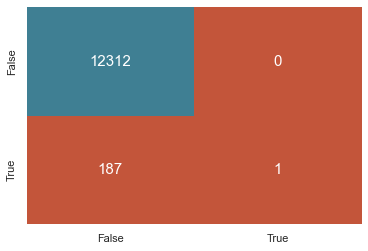

Accuracy: 0.98504
Precision: 1.0
Recall: 0.005319148936170213
Average precision-recall score: 0.08


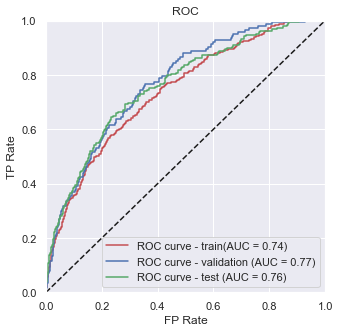

Area under the ROC curve - train: 0.737945
Area under the ROC curve - val: 0.770025
Area under the ROC curve - test: 0.760573


In [36]:
evaluation(lg, X_train, X_valid, X_test, y_train, y_valid, y_test, threshold = 0.35)

Logistic regression model (with SMOT oversampling) perform better compared with simple logistic regression model. With detailed comparison showed in the following figure:

![](modelresult.png)

**Optimized model is evaluated as**
- Accuracy: 0.9780407037962063
- Precision: 0.13309134906231096
- Recall: 0.07087628865979381
- Average precision-recall score: 0.06
- Average precision-recall score: 0.06
- Area under the ROC curve : 0.748089

### <a class="anchor" id="ref">Part V: Reference</a>

https://seaborn.pydata.org/generated/seaborn.heatmap.html
<br> https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
<br> http://localhost:8889/tree/Documents/Github/scikit-learn-videos

# Useful Tool Examples

## Face Image Dataset

In this part of the exercise, you will run PCA on face images to see how it
can be used in practice for dimension reduction. The dataset **pcafaces.mat**
contains a dataset **X** of face images, each $32 \times 32$ in grayscale. Each row
of **X**  corresponds to one face image (a row vector of length 1024). The next
cell will load and visualize the first 100 of these face images.

## PCA on faces
To run PCA on the face dataset, we first normalize the dataset by subtracting
the mean of each feature from the data matrix **X**. The cell below will
do this for you and then run your PCA function. After running PCA, you will
obtain the principal components of the dataset. Notice that each principal
component in U (each row) is a vector of length $d$ (where for the face dataset,
$d = 1024$). It turns out that we can visualize these principal components by
reshaping each of them into a $32\times 32$ matrix that corresponds to the pixels
in the original dataset. The cell below displays the first 25 principal
components that describe the largest variations. If you want, you
can also change the code below  to display more principal components to see how
they capture more and more details.

In [37]:
import scipy.io
import numpy as np
import utils_pca
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

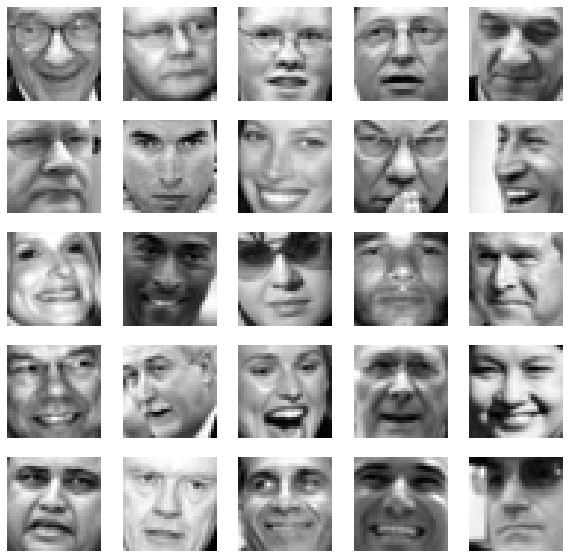

<Figure size 720x720 with 0 Axes>

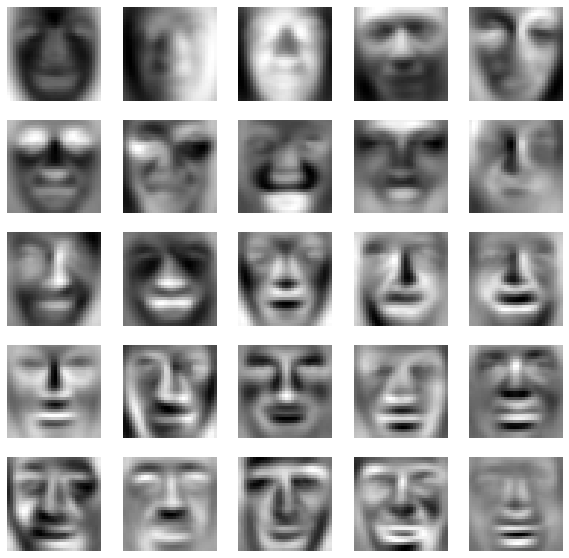

In [38]:
# PCA on the faces data set
faces_data = scipy.io.loadmat('pcafaces.mat')
faces = faces_data['X']

# visualize the first 25 faces
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(faces[i,:].reshape((32,32)).T)
    
# normalize the faces data set
faces_norm, mu_faces, sigma_faces = utils_pca.feature_normalize(faces)

# run PCA
U_faces, S_faces, V_faces = utils_pca.pca(faces_norm)

plt.figure()
#plt.plot(S_faces)

plt.figure()
# top 25 eigenfaces
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(U_faces[:,i].reshape((32,32)).T)

## Dimensionality reduction
Now that you have computed the principal components for the face dataset,
you can use it to reduce the dimension of the face dataset. This allows you to
use your learning algorithm with a smaller input size (e.g., 100 dimensions)
instead of the original 1024 dimensions. This can help speed up your learning
algorithm.

The next cell will project the face dataset onto only the
first 100 principal components. Concretely, each face image is now described
by a vector $z^{(i)} \in \Re^{100}$. 
To understand what is lost in the dimension reduction, you can recover
the data using only the projected dataset. An approximate
recovery of the data is performed and the original and projected face images
are displayed side by side (Figure 8). From the reconstruction, you can observe
that the general structure and appearance of the face are kept while
the fine details are lost. This is a remarkable reduction (more than $10 \times$) in
the dataset size that can help speed up your learning algorithm significantly.
For example, if you were training a neural network to perform person recognition
(given a face image, predict the identitfy of the person), you can use
the dimension reduced input of only a 100 dimensions instead of the original
pixels.

### To-do play with K and find the threshold

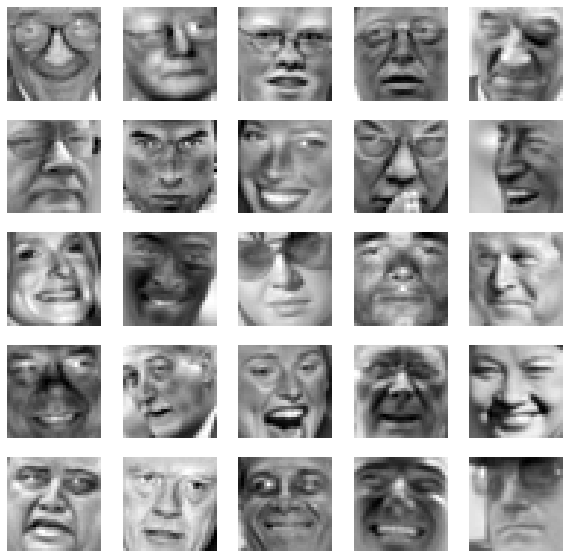

############################################################


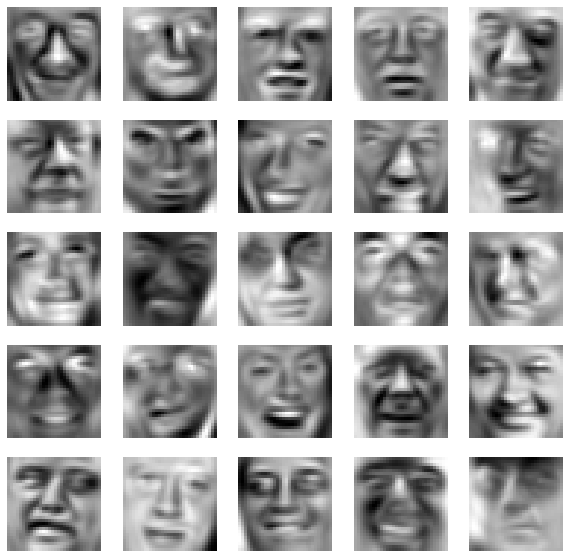

In [39]:
# show the recovered faces constructed out of top 100 principal components
K = 100
Z_faces = utils_pca.project_data(faces_norm,U_faces,K)
faces_rec = utils_pca.recover_data(Z_faces,U_faces,K)

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(faces_norm[i,:].reshape((32,32)).T)
plt.show()

print('############################################################')

plt.figure()
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(faces_rec[i,:].reshape((32,32)).T)